In [42]:
include("landing_script.jl")
using Plots

N = 40
dimLinearConstraintsU = 3
dimSecondOrderConeConstraintsU = 0
MAX_ITERATIONS_NB = 10

model = Landing()

Xp,Up = initialize_trajectory(model, N)
X, U  = copy(Xp), copy(Up)

SCPproblem = GuSTOProblem(model, N, dimLinearConstraintsU, dimSecondOrderConeConstraintsU, Xp, Up)

x_dim, u_dim = model.x_dim, model.u_dim

Delta0, omega0, omegamax, 
epsilon, rho0, rho1, 
beta_succ, beta_fail, gamma_fail, 
convergence_threshold = get_initial_gusto_parameters(model)

Delta = Delta0
omega = omega0

1.0

In [43]:
X_all, U_all, x_shooting_all = [], [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

B_success = false
it = 0

while it<MAX_ITERATIONS_NB && 
        !(B_success &&
            convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
        omega<omegamax
    println("-----------")
    println("Iteration $it")
    #println("metric=$(convergence_metric(model,X,U,Xp,Up))")
    println("-----------")
    
    #omega, Delta = SCPproblem.omega, SCPproblem.Delta
    
    Xp = copy(X)
    Up = copy(U)
    
    model.f, model.A, model.B = compute_dynamics(model, Xp, Up)
    
    reset_problem(SCPproblem, model)
    set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    JuMP.optimize!(SCPproblem.solver_model)
    
    # get solution
    X_sol = JuMP.value.(SCPproblem.X)
    U_sol = JuMP.value.(SCPproblem.U)
    
    # -----------
    # GuSTO Logic
    if it > 0
        if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
            rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

            if rho > rho1
                println("Reject solution.")
                Delta = beta_fail * Delta
                omega     = omega
                B_success = false

            else
                println("Accept solution.")
                X = copy(X_sol)
                U = copy(U_sol)
                B_success = true
                if rho < rho0
                    Delta = min(beta_succ*Delta, Delta0)
                else
                    Delta = Delta
                end
                if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                    omega = omega0
                else
                    println("Solution does not satisfy state constraints, increasing omega.")
                    omega = gamma_fail * omega
                    B_success = false
                end
            end

        else
            println("Reject solution (Outside trust region)")
            Delta = Delta
            omega     = gamma_fail * omega
            B_success = false
        end
    else # always accept first solution
        X = copy(X_sol)
        U = copy(U_sol)
    end
        
                    
    # -----------

    push!(X_all, copy(X))
    push!(U_all, copy(U))
                    
    
    it += 1
    
    println("Parameters:")
    println("omega=$omega")
    println("delta=$Delta")
    println("metric=$(convergence_metric(model,X,U,Xp,Up))")
end


-----------
Iteration 0
-----------
Parameters:
omega=1.0
delta=1.0e6
metric=44.95375580092514
-----------
Iteration 1
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
Parameters:
omega=5.0
delta=1.0e6
metric=99.96740583839905
-----------
Iteration 2
-----------
Reject solution (Outside trust region)
Parameters:
omega=25.0
delta=1.0e6
metric=0.0
-----------
Iteration 3
-----------
Reject solution (Outside trust region)
Parameters:
omega=125.0
delta=1.0e6
metric=0.0
-----------
Iteration 4
-----------
Reject solution (Outside trust region)
Parameters:
omega=625.0
delta=1.0e6
metric=0.0
-----------
Iteration 5
-----------
Reject solution (Outside trust region)
Parameters:
omega=3125.0
delta=1.0e6
metric=0.0
-----------
Iteration 6
-----------
Reject solution (Outside trust region)
Parameters:
omega=15625.0
delta=1.0e6
metric=0.0
-----------
Iteration 7
-----------
Reject solution (Outside trust region)
Parameters:
omega=78125.0
delta=1.0e6
metri

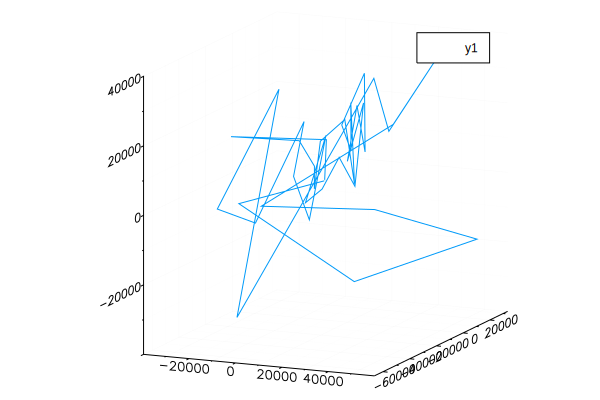

In [33]:
#Xp,Up = initialize_trajectory(model, N)
#plot(Xp[1,:],Xp[2,:])
# timeSpan = zeros(N-1)
# normU = zeros(N-1)
# normU[1] = sqrt(U_all[end][1,1]^2 + U_all[end][2,1]^2 + U_all[end][3,1]^2)
# for i = 1:N-2
#     timeSpan[i+1] = timeSpan[i] + 2.0/N
#     normU[i+1] = sqrt(U_all[end][1,i+1]^2 + U_all[end][2,i+1]^2 + U_all[end][3,i+1]^2)
# end
# plot(timeSpan,normU,ylims=(0,25),linewidth=3,label="")

# plot_solutions(SCPproblem, model, X_all[end-2:end], U_all[end-2:end]; x_shooting_all=x_shooting_all)

plot3d(X[1,:],X[2,:],X[3,:])